
# 📝 Data Analysis and Conventional Model Testing on G-Research Crypto Dataset for Time Series Forecasting


In [1]:
# Import packages
import opendatasets as od
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor


## Downloading the Data
The dataset is obtained from kaggle. The dataset contains information on historic trades for several cryptoassets, such as Bitcoin and Ethereum.

data_url = 'https://www.kaggle.com/c/g-research-crypto-forecasting/data'
od.download(data_url)

In [2]:
data_dir = './g-research-crypto-forecasting'

In [3]:
os.listdir(data_dir)

['asset_details.csv',
 'example_sample_submission.csv',
 'test.csv',
 'supplemental_train.csv',
 'train.csv']

##  Data Preparation and Cleaning
In this section, `train.csv` will be read in. The training set has the following variables
- `timestamp` - A timestamp for the minute covered by the row.
- `Asset_ID` - An ID code for the cryptoasset.
- `Count` - The number of trades that took place this minute.
- `Open` - The USD price at the beginning of the minute.
- `High` - The highest USD price during the minute.
- `Low` - The lowest USD price during the minute.
- `Close` - The USD price at the end of the minute.
- `Volume` - The number of cryptoasset units traded during the minute.
- `VWAP` - The volume weighted average price for the minute.
- `Target` - 15 minute residualized returns.

The following variables will be created based on the `timestamp` column.
- `hour` is the hour of the day
- `weekday` is the weekday of the week

Categorical variables (`Asset_ID`, `hour`, and  `weekday`) will be on hot encoded.

Numeric variables (`Count`, `Open`, `High`, `Low`, `Close`, `Volume`, and `VWAP`) will be scaled to the value of 0 to 1 for each of the `Asset_ID`.

### Read in Dataset

In [4]:
train_df = pd.read_csv('./g-research-crypto-forecasting/train.csv')
asset_details_df = pd.read_csv('./g-research-crypto-forecasting/asset_details.csv')
test_df = pd.read_csv('./g-research-crypto-forecasting/test.csv')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [6]:
train_df.shape

(24236806, 10)

In [7]:
asset_details_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


The training set has 18 million records and 10 columns.

Subset to data in November of 2020 to reduce the run time of the model.

In [8]:
# Convert timestamp to date time
train_df['timestamp'] = train_df.timestamp.astype('datetime64[s]')
train_df = train_df[train_df.timestamp.dt.year==2020]
train_df = train_df[train_df.timestamp.dt.month==11]
train_df.shape

(598769, 10)

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598769 entries, 17714600 to 18313368
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  598769 non-null  datetime64[ns]
 1   Asset_ID   598769 non-null  int64         
 2   Count      598769 non-null  float64       
 3   Open       598769 non-null  float64       
 4   High       598769 non-null  float64       
 5   Low        598769 non-null  float64       
 6   Close      598769 non-null  float64       
 7   Volume     598769 non-null  float64       
 8   VWAP       598769 non-null  float64       
 9   Target     589955 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 50.3 MB


The reduced training set has 471,372 records.

### Handeling Missing Values
Check missing values

In [10]:
train_df.isna().sum()

timestamp       0
Asset_ID        0
Count           0
Open            0
High            0
Low             0
Close           0
Volume          0
VWAP            0
Target       8814
dtype: int64

There are 8,343 (1.77%) of recrods with missing target variable.

In [11]:
train_df.isin([np.nan, np.inf, -np.inf]).sum()

timestamp       0
Asset_ID        0
Count           0
Open            0
High            0
Low             0
Close           0
Volume          0
VWAP            0
Target       8814
dtype: int64

There is 1 record with infinity or missing values for `Low`, `Close`, `Colume` and `VWAP` column. The following code will drop the missing values and infinity values.

In [12]:
train_df.dropna(inplace=True)
train_df = train_df[np.isfinite(train_df).all(1)]

In [13]:
train_df.describe()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,589955.000000,589955.000000,589955.000000,589955.000000,589955.000000,589955.000000,5.899550e+05,589955.000000,589955.000000
mean,6.473456,285.892887,1320.409986,1322.450504,1318.366282,1320.418393,3.544014e+05,1320.401154,0.000027
std,4.068315,628.253640,4301.293082,4307.891268,4294.558528,4301.324037,1.416194e+06,4301.260318,0.004511
min,0.000000,1.000000,0.002451,0.002453,0.002450,0.002452,6.000000e-05,0.002452,-0.126551
25%,3.000000,28.000000,0.128017,0.128417,0.127590,0.128001,1.872239e+02,0.127994,-0.001631
50%,6.000000,80.000000,27.651600,27.671300,27.629000,27.651700,2.062042e+03,27.651692,-0.000049
75%,10.000000,262.000000,262.734500,263.210000,262.340000,262.732917,6.408410e+04,262.729967,0.001547
max,13.000000,38146.000000,19842.913750,19873.230000,19762.400000,19840.008750,1.539141e+08,19826.506346,0.089697


### Feature Engineering
The following code converts `timestamp` to date time type and creates variables `hour` and `weekday` based on the value of column `timestamp`.

In [14]:
# Create hour variable
train_df['hour'] = train_df.timestamp.dt.hour

# Create weekday variable
train_df['weekday'] = train_df.timestamp.dt.weekday

In [15]:
train_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,hour,weekday
17714600,2020-11-01 00:01:00,3,61.0,0.092705,0.092764,0.092566,0.092626,165852.794349,0.092651,0.001047,0,6
17714601,2020-11-01 00:01:00,2,163.0,261.896000,262.160000,261.590000,261.904000,198.574079,261.854820,-0.002429,0,6
17714602,2020-11-01 00:01:00,0,150.0,28.347800,28.362300,28.303400,28.342000,5011.629000,28.328415,-0.005357,0,6
17714603,2020-11-01 00:01:00,1,2445.0,13734.228920,13754.300000,13720.000000,13741.110730,213.517157,13737.261551,0.000794,0,6
17714604,2020-11-01 00:01:00,4,10.0,0.002560,0.002562,0.002558,0.002561,117420.170000,0.002561,0.004920,0,6


### One Hot Encode Categorical Variables
This section will convert variables `Asset_ID`, `hour` and `weekday` to categorical variables and create one hot encoder for categorical variables

In [16]:
# Convert Asset_ID, hour and weekday to categorical
train_df['Asset_ID'] = train_df.Asset_ID.astype('category')
train_df['hour'] = train_df.hour.astype('category')
train_df['weekday'] = train_df.weekday.astype('category')

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589955 entries, 17714600 to 18313368
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  589955 non-null  datetime64[ns]
 1   Asset_ID   589955 non-null  category      
 2   Count      589955 non-null  float64       
 3   Open       589955 non-null  float64       
 4   High       589955 non-null  float64       
 5   Low        589955 non-null  float64       
 6   Close      589955 non-null  float64       
 7   Volume     589955 non-null  float64       
 8   VWAP       589955 non-null  float64       
 9   Target     589955 non-null  float64       
 10  hour       589955 non-null  category      
 11  weekday    589955 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(8)
memory usage: 46.7 MB


In [18]:
# Set up Encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# fit onehotcoder
encoder.fit(train_df[['Asset_ID','hour','weekday']])

/Users/devangdayal/opt/anaconda3/envs/Workspace/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)

In [19]:
encoder.categories_

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([0, 1, 2, 3, 4, 5, 6])]

<b>First Array showing the 0-13 
i.e., The number of asset ID in the dataset</b> and so on it goes 

In [20]:
encoder.get_feature_names_out(['Asset_ID','hour','weekday'])

array(['Asset_ID_0', 'Asset_ID_1', 'Asset_ID_2', 'Asset_ID_3',
       'Asset_ID_4', 'Asset_ID_5', 'Asset_ID_6', 'Asset_ID_7',
       'Asset_ID_8', 'Asset_ID_9', 'Asset_ID_10', 'Asset_ID_11',
       'Asset_ID_12', 'Asset_ID_13', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype=object)

In [21]:
# get new encoded cols names
encoded_cols = list(encoder.get_feature_names_out(['Asset_ID','hour','weekday']))
encoded_cols

['Asset_ID_0',
 'Asset_ID_1',
 'Asset_ID_2',
 'Asset_ID_3',
 'Asset_ID_4',
 'Asset_ID_5',
 'Asset_ID_6',
 'Asset_ID_7',
 'Asset_ID_8',
 'Asset_ID_9',
 'Asset_ID_10',
 'Asset_ID_11',
 'Asset_ID_12',
 'Asset_ID_13',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6']

In [22]:
# replace categorical variables with one hot encoder
train_df[encoded_cols] = encoder.transform(train_df[['Asset_ID','hour','weekday']])

In [23]:
train_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
17714600,2020-11-01 00:01:00,3,61.0,0.092705,0.092764,0.092566,0.092626,165852.794349,0.092651,0.001047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714601,2020-11-01 00:01:00,2,163.0,261.896000,262.160000,261.590000,261.904000,198.574079,261.854820,-0.002429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714602,2020-11-01 00:01:00,0,150.0,28.347800,28.362300,28.303400,28.342000,5011.629000,28.328415,-0.005357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714603,2020-11-01 00:01:00,1,2445.0,13734.228920,13754.300000,13720.000000,13741.110730,213.517157,13737.261551,0.000794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714604,2020-11-01 00:01:00,4,10.0,0.002560,0.002562,0.002558,0.002561,117420.170000,0.002561,0.004920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Scale Numeric Variables
This section will scale numeric variables `Count`, `Open`, `High`, `Low`, `Close`, `Volume`, and `VWAP` to range from 0 to 1.

In [24]:
scaler = MinMaxScaler()

num_cols = ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']

scaler.fit(train_df[num_cols])
train_df[num_cols] = scaler.transform(train_df[num_cols])

In [25]:
train_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
17714600,2020-11-01 00:01:00,3,0.001573,4.548390e-06,4.544355e-06,4.559973e-06,4.545024e-06,0.001078,4.549415e-06,0.001047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714601,2020-11-01 00:01:00,2,0.004247,1.319834e-02,1.319149e-02,1.323663e-02,1.320068e-02,0.000001,1.320719e-02,-0.002429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714602,2020-11-01 00:01:00,0,0.003906,1.428487e-03,1.427038e-03,1.432061e-03,1.428404e-03,0.000033,1.428692e-03,-0.005357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714603,2020-11-01 00:01:00,1,0.064071,6.921478e-01,6.921018e-01,6.942476e-01,6.925960e-01,0.000001,6.928735e-01,0.000794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17714604,2020-11-01 00:01:00,4,0.000236,5.478027e-09,5.499862e-09,5.464924e-09,5.478829e-09,0.000763,5.475302e-09,0.004920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Exploratory Analysis
This section explores the association between each variables and the target variable.

#### Time Series Plots
The following code get the time range for each of the `Asset_ID`.

In [26]:
train_df.groupby(["Asset_ID"]).agg({'timestamp': [np.min,np.max]})

timestamp                    
                        amin                amax
Asset_ID                                        
0        2020-11-01 00:01:00 2020-11-30 23:59:00
1        2020-11-01 00:01:00 2020-11-30 23:59:00
2        2020-11-01 00:01:00 2020-11-30 23:59:00
3        2020-11-01 00:01:00 2020-11-30 23:59:00
4        2020-11-01 00:01:00 2020-11-30 23:59:00
5        2020-11-01 00:01:00 2020-11-30 23:59:00
6        2020-11-01 00:01:00 2020-11-30 23:59:00
7        2020-11-01 00:01:00 2020-11-30 23:59:00
8        2020-11-01 00:01:00 2020-11-30 23:59:00
9        2020-11-01 00:01:00 2020-11-30 23:59:00
10       2020-11-01 00:01:00 2020-11-30 23:59:00
11       2020-11-01 00:01:00 2020-11-30 23:59:00
12       2020-11-01 00:01:00 2020-11-30 23:59:00
13       2020-11-01 00:01:00 2020-11-30 23:59:00

The date range is slightly different for each of the asset.

<AxesSubplot: xlabel='timestamp', ylabel='Target'>

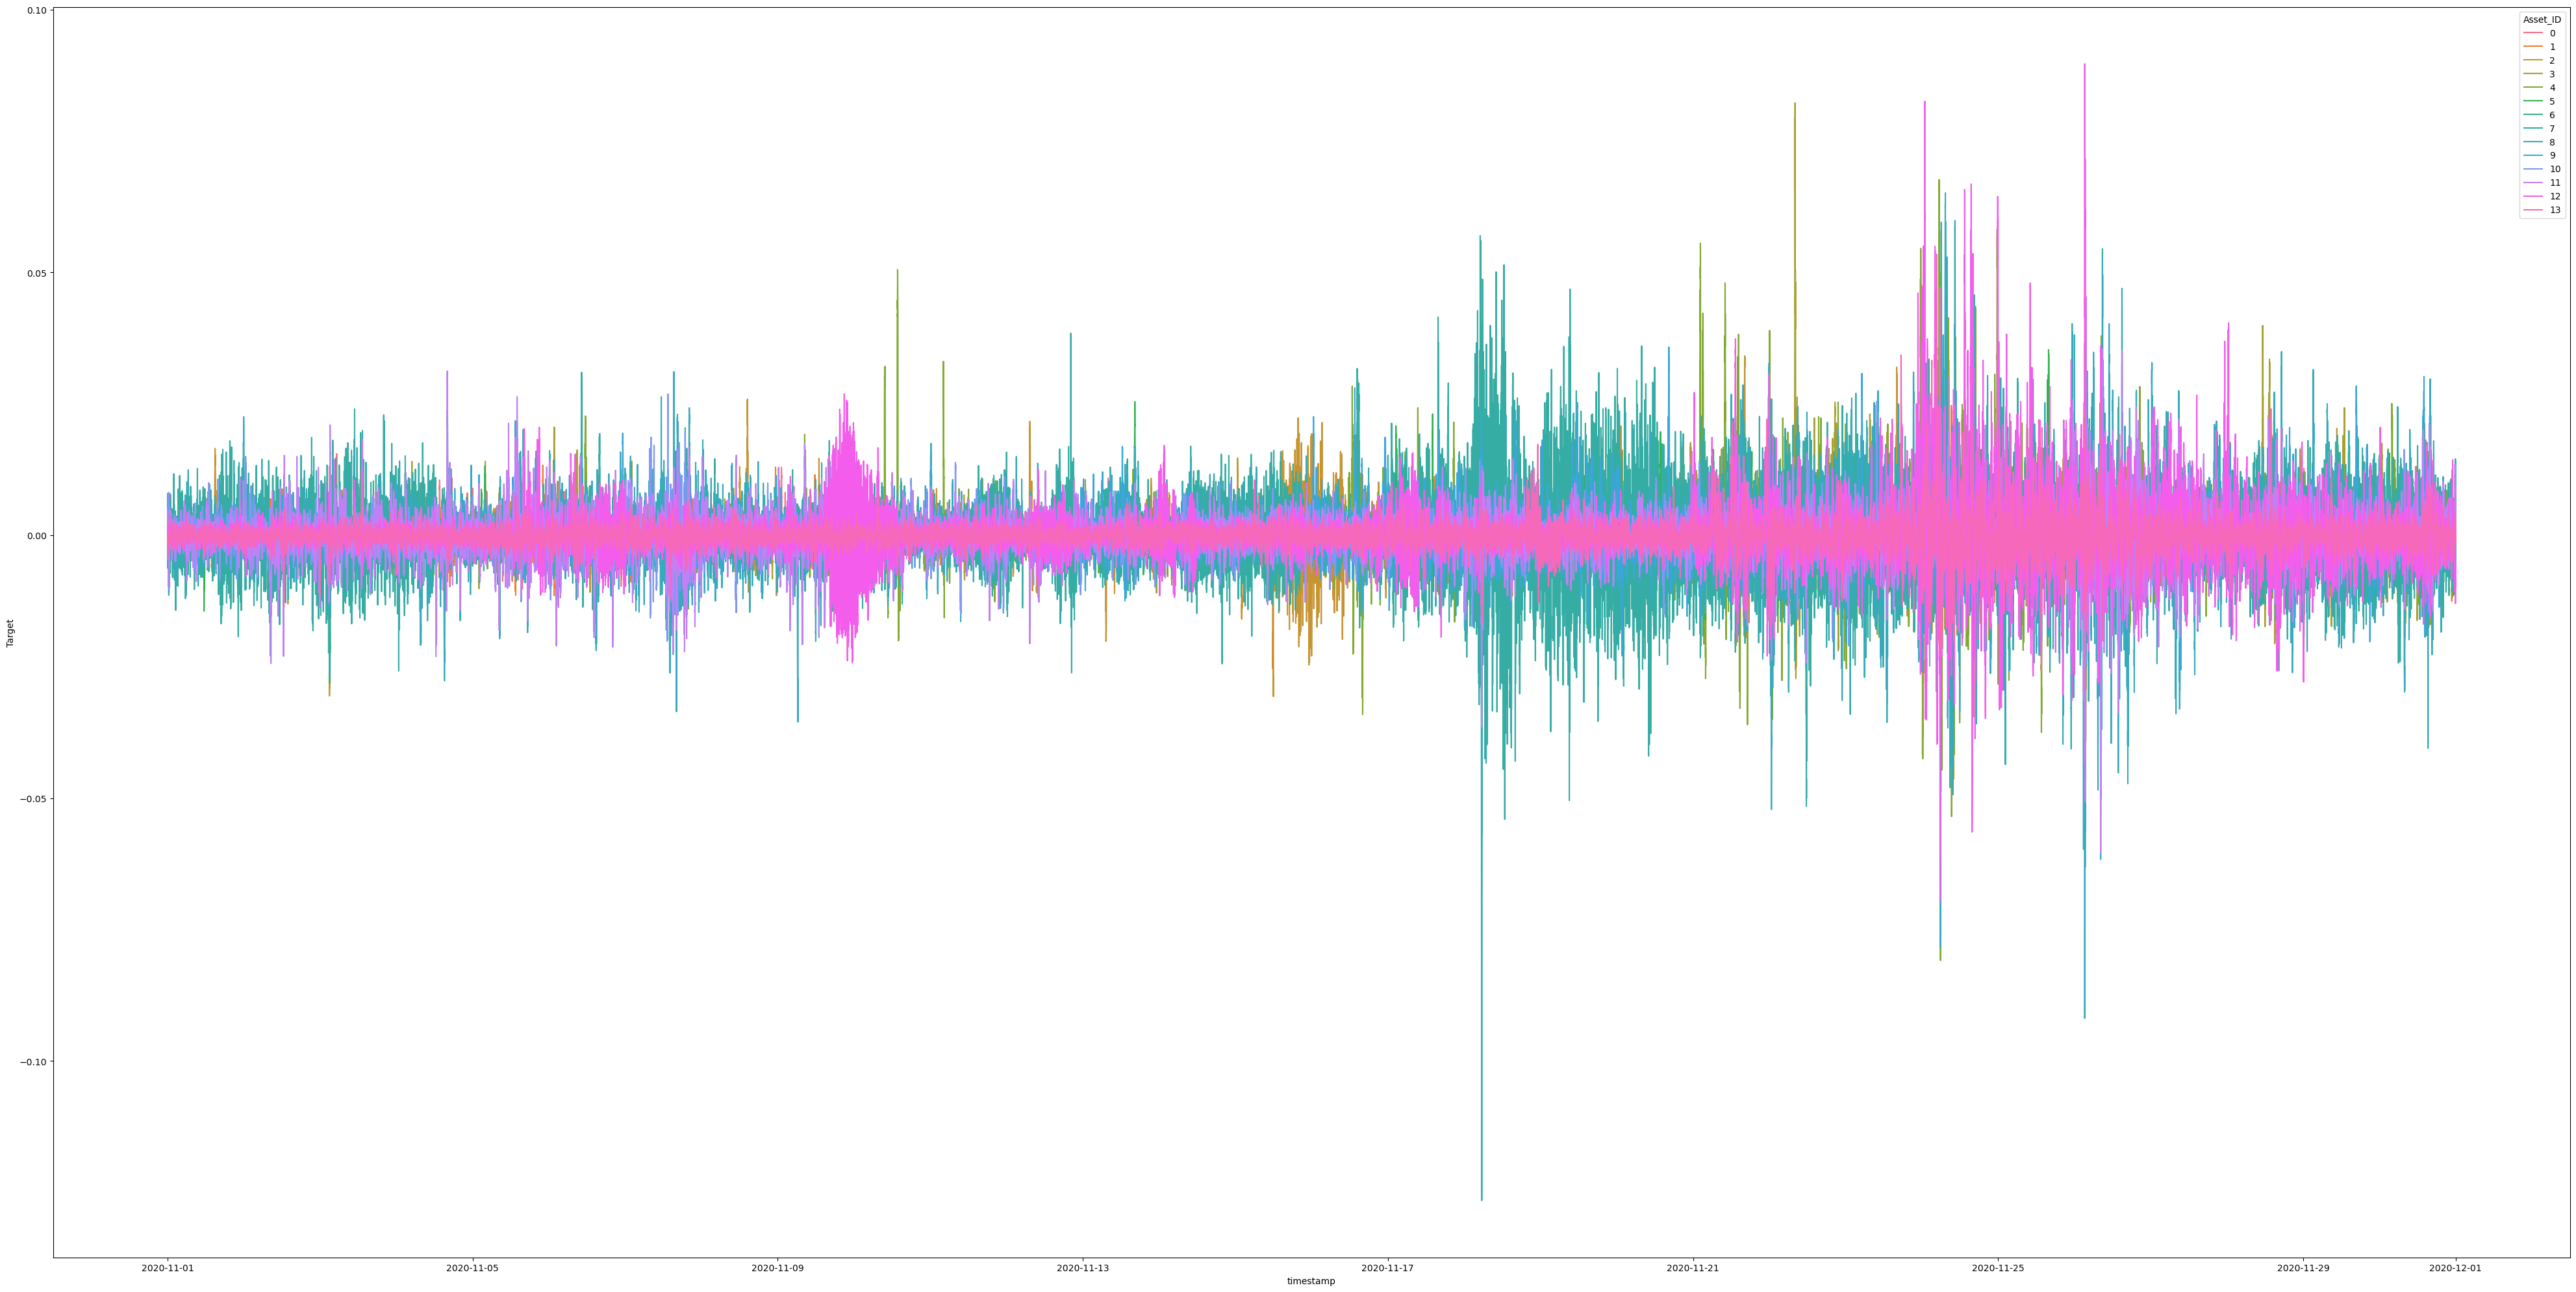

In [27]:
plt.figure(figsize=(50, 25))
sns.lineplot(data=train_df, x="timestamp", y="Target", hue="Asset_ID")

The `Target` variable has very different patterns for each of the asset of interest.

#### Correlation Matrix
The following code provide correlation matrix for each of the asset.

<AxesSubplot: >

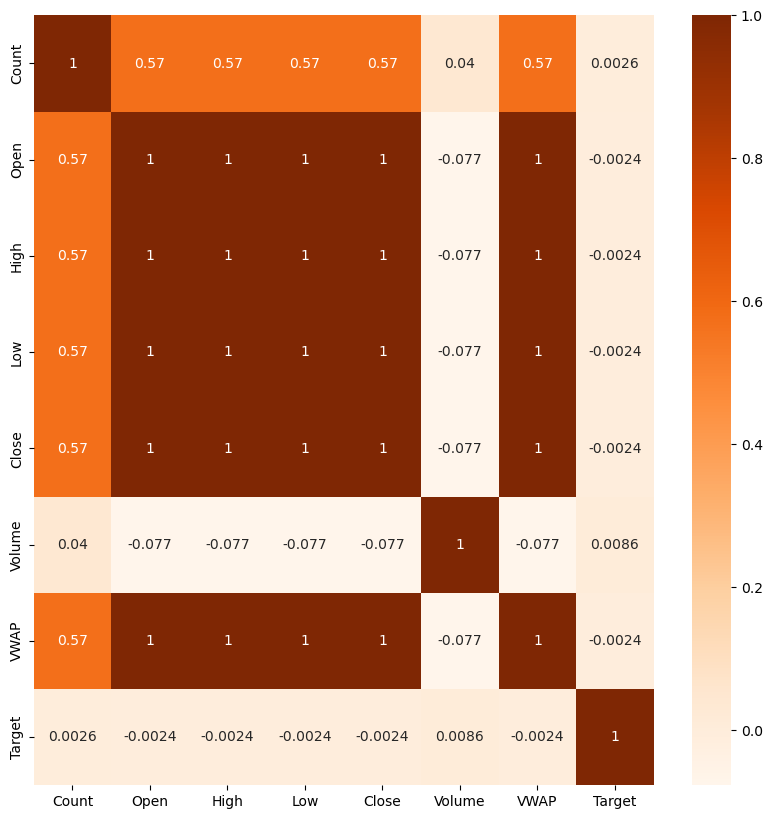

In [28]:
corr_matrix = train_df[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix,annot=True, cmap='Oranges')

The `Open`, `High`, `Low`, `Close`, and `VWAP` are highly correlated.

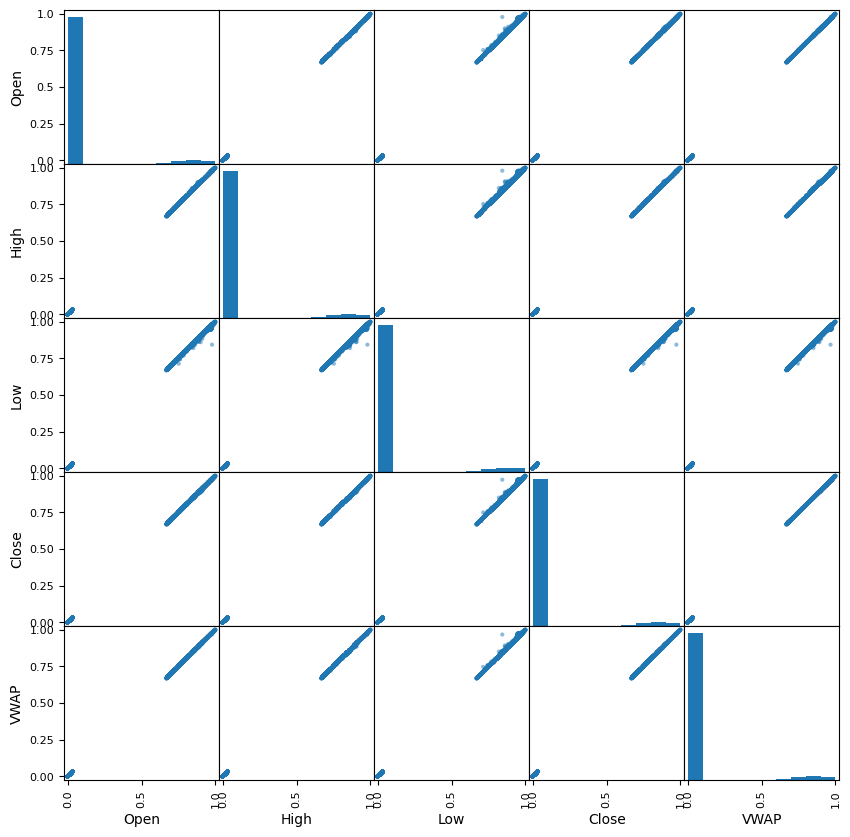

In [29]:
# Scatter Plot to Visualise the Correlation of the Parameter

from pandas.plotting import scatter_matrix as scatMat

scatMat(train_df[['Open','High','Low','Close','VWAP']],
        figsize=(10,10))
plt.show()


### Training and Testing Split
We will use data from November 1st - 20th as training set, use the rest data in November as validation set. The testing set is provided in `test.csv` file.

In [30]:
train_set = train_df[train_df.timestamp.dt.day <= 20]
val_set = train_df[train_df.timestamp.dt.day > 20]

In [31]:
val_set.to_csv('val-crpyto.csv')
train_set.to_csv('train-crpyto.csv')

In [ ]:
train_set.shape

(389242, 57)

In [ ]:
val_set.shape

(200713, 57)

In [ ]:
train_set.Asset_ID.value_counts()

0     28799
1     28799
2     28799
3     28799
5     28799
6     28799
9     28799
10    28799
12    28799
13    28799
7     28745
11    27874
4     26595
8     18038
Name: Asset_ID, dtype: int64

In [ ]:
val_set.Asset_ID.value_counts()

1     14400
2     14400
3     14400
5     14400
6     14400
7     14400
9     14400
10    14400
12    14400
13    14400
4     14368
11    14332
0     14329
8     13684
Name: Asset_ID, dtype: int64

`Training set has 389,242 observations and validation set has 73,787 observations. And the number of observations for each asset is relatively balanced.`

## Random Forest
This section build random forest to predict the `Target` variable.

In [ ]:
# Create the model
rf1 = RandomForestRegressor(random_state=5, n_jobs = -1)

In [ ]:
# Fit the model
input_cols = num_cols + encoded_cols
target_col = 'Target'

rf1.fit(train_set[input_cols], train_set[target_col])

RandomForestRegressor(n_jobs=-1, random_state=5)

In [ ]:
# Model Evaluation
tree_train_preds = rf1.predict(train_set[input_cols])
tree_val_preds = rf1.predict(val_set[input_cols])

tree_train_rmse = mean_squared_error(train_set[target_col], tree_train_preds, squared=False)
tree_val_rmse = mean_squared_error(val_set[target_col], tree_val_preds, squared=False)

print("Train Error is ", tree_train_rmse)
print("Validation Error is ", tree_val_rmse)

Train Error is  0.0010756987696543356
Validation Error is  0.0070265793929239475


The validation error is higher than the training error, which indicates the potential of overfitting.

Tunning the hyperparameters to achive better fits to validation set. 

In [ ]:
# functions for hyperparameter tunning
def test_params(**params):
    model = RandomForestRegressor(random_state=5, n_jobs=-1, **params).fit(train_set[input_cols], train_set[target_col])
    train_rmse = mean_squared_error(model.predict(train_set[input_cols]), train_set[target_col], squared=False)
    val_rmse = mean_squared_error(model.predict(val_set[input_cols]), val_set[target_col], squared=False)
    return train_rmse, val_rmse

def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

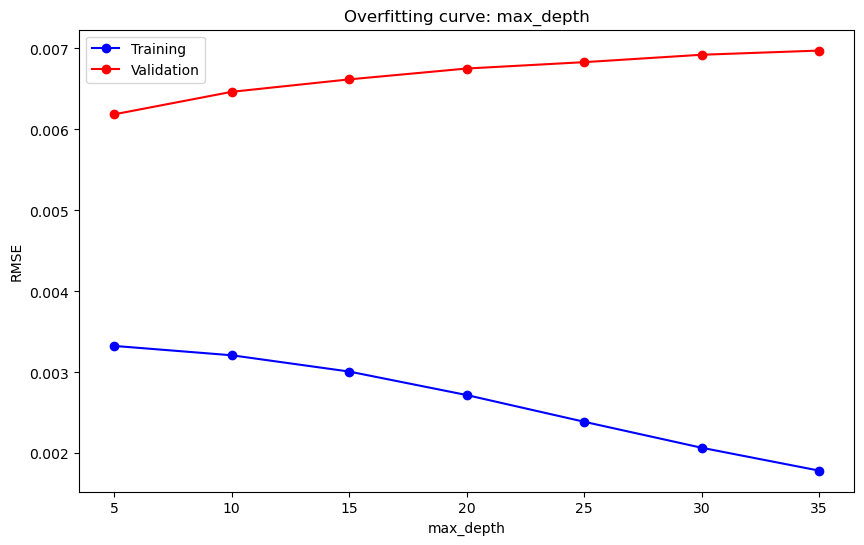

In [ ]:
# max_depth
test_param_and_plot('max_depth', [5, 10, 15, 20, 25, 30, 35])

5 is a reasonable max_depth choice.

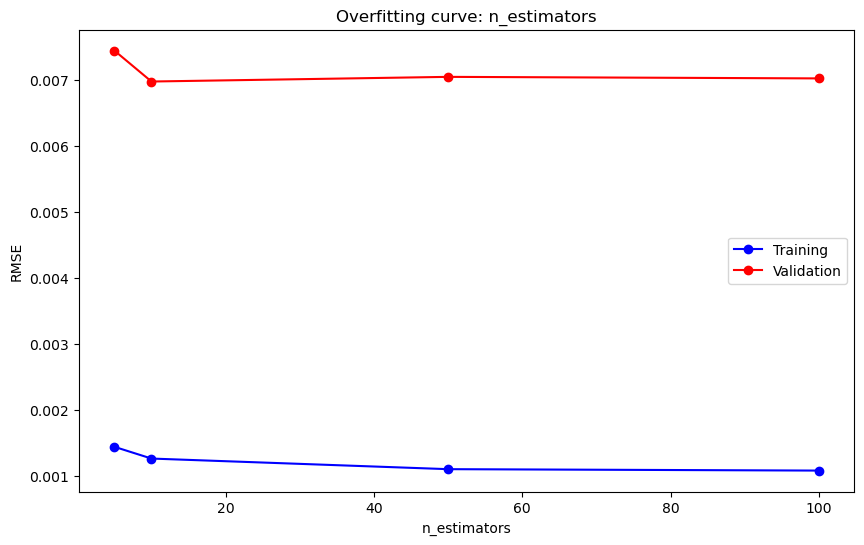

In [ ]:
# n_estimators
test_param_and_plot('n_estimators', [5, 10, 50, 100])

10 is a reasonable n_estimators choice.

In [ ]:
rf2 = RandomForestRegressor(random_state=5, n_jobs = -1, max_depth=5, n_estimators=10)

rf2.fit(train_set[input_cols], train_set[target_col])

tree_train_preds = rf2.predict(train_set[input_cols])
tree_val_preds = rf2.predict(val_set[input_cols])

tree_train_rmse = mean_squared_error(train_set[target_col], tree_train_preds, squared=False)
tree_val_rmse = mean_squared_error(val_set[target_col], tree_val_preds, squared=False)

print("Train Error is ", tree_train_rmse)
print("Validation Error is ", tree_val_rmse)

Train Error is  0.003323058937477169
Validation Error is  0.00618923461909251


The training set error is 0.33% and the validation set error is 0.61%, which indicates an improvement of the original model.

The following code gets the feature importance.

In [ ]:
rf2_importance_df = pd.DataFrame({
    'feature': train_set[input_cols].columns,
    'importance': rf2.feature_importances_
}).sort_values('importance', ascending=False)

<AxesSubplot: xlabel='importance', ylabel='feature'>

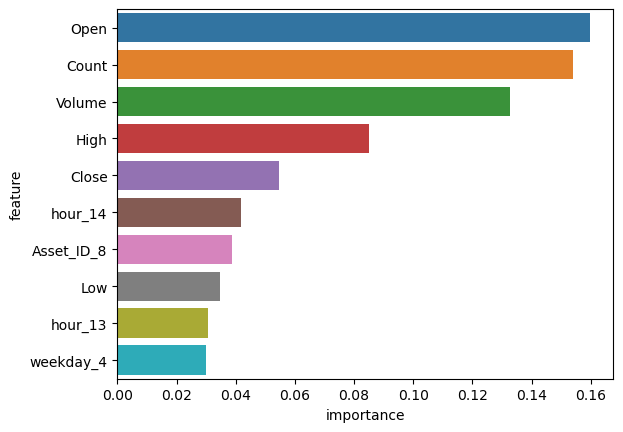

In [ ]:
sns.barplot(data=rf2_importance_df.head(10), x='importance', y='feature')

## Gradient Boosting
This section fits grandiant boosting model.

In [ ]:
# Create the model
GB = XGBRegressor(random_state=5, n_jobs=-1, n_estimators=20, max_depth=4)

In [ ]:
# Fit the model
GB.fit(train_set[input_cols], train_set[target_col])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=5, ...)

In [ ]:
# Model Evaluation
GB_train_preds = GB.predict(train_set[input_cols])
GB_val_preds = GB.predict(val_set[input_cols])

GB_train_rmse = mean_squared_error(train_set[target_col], GB_train_preds, squared=False)
GB_val_rmse = mean_squared_error(val_set[target_col], GB_val_preds, squared=False)

print("Train Error is ", GB_train_rmse)
print("Validation Error is ", GB_val_rmse)

Train Error is  0.003308175509393353
Validation Error is  0.006228947587064762


The training set error is 0.33% and the validation set error is 0.70%, similar to the tuned random forest.

In [ ]:
# functions for hyperparameter tunning
def test_params(**params):
    model = XGBRegressor(random_state=5, n_jobs=-1, **params).fit(train_set[input_cols], train_set[target_col])
    train_rmse = mean_squared_error(model.predict(train_set[input_cols]), train_set[target_col], squared=False)
    val_rmse = mean_squared_error(model.predict(val_set[input_cols]), val_set[target_col], squared=False)
    return train_rmse, val_rmse

def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

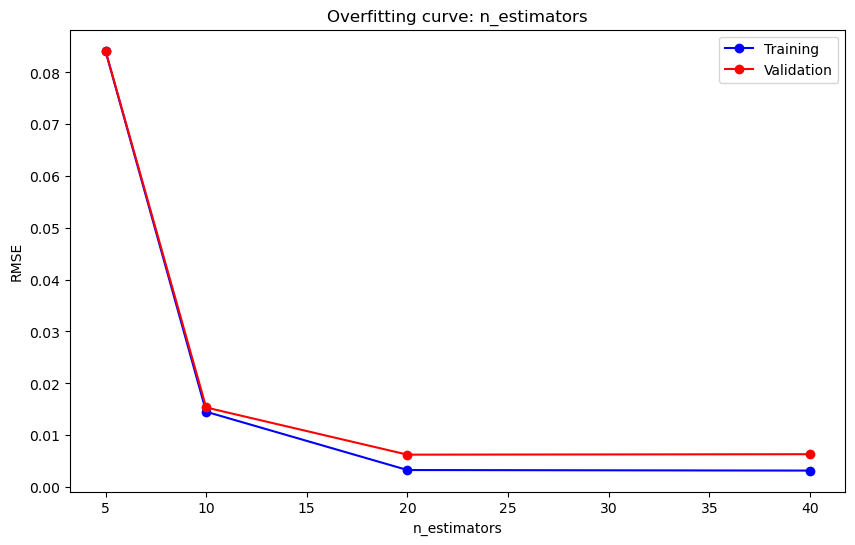

In [ ]:
# n_estimators
test_param_and_plot('n_estimators', [5, 10, 20, 40])

n_estimators of 20 seems to be a reasonable choice

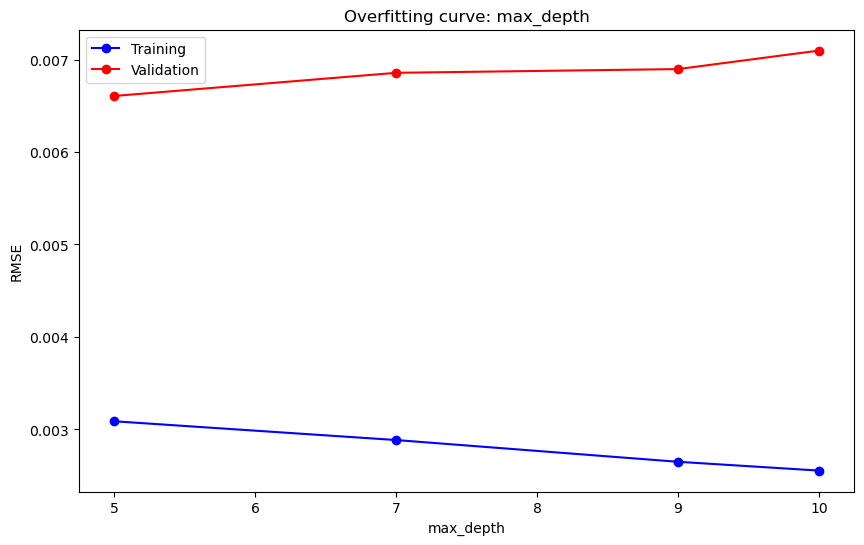

In [ ]:
# max_depth
test_param_and_plot('max_depth', [5, 7, 9, 10])

max_depth of 5 seems to be a reasonable choice.

In [ ]:
# tuned model
GB2 = XGBRegressor(random_state=5, n_jobs=-1, n_estimators=20, max_depth=5)

GB2.fit(train_set[input_cols], train_set[target_col])

GB_train_preds = GB2.predict(train_set[input_cols])
GB_val_preds = GB2.predict(val_set[input_cols])

GB_train_rmse = mean_squared_error(train_set[target_col], GB_train_preds, squared=False)
GB_val_rmse = mean_squared_error(val_set[target_col], GB_val_preds, squared=False)

print("Train Error is ", GB_train_rmse)
print("Validation Error is ", GB_val_rmse)

Train Error is  0.003288031899304685
Validation Error is  0.006223192625341307


The performance is very similar to the untuned grandiant booster model and the tuned random forest.

## Sample Predictions on Testing Set
The following code prepare the testing set.

In [ ]:
# Prepare test_df
test_df['timestamp'] = test_df.timestamp.astype('datetime64[s]')

# Create hour variable
test_df['hour'] = test_df.timestamp.dt.hour

# Create weekday variable
test_df['weekday'] = test_df.timestamp.dt.weekday

# Convert categorical variables
test_df['Asset_ID'] = test_df.Asset_ID.astype('category')
test_df['hour'] = test_df.hour.astype('category')
test_df['weekday'] = test_df.weekday.astype('category')

# one hot encoder categorical variables
test_df[encoded_cols] = encoder.transform(test_df[['Asset_ID','hour','weekday']])

# scale numeric variables
test_df[num_cols] = scaler.transform(test_df[num_cols])

test_df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,group_num,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2021-06-13,3,0.031459,0.000074,0.000075,0.000075,0.000075,0.004254,0.000075,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2021-06-13,2,0.026714,0.029245,0.029381,0.029344,0.029348,0.000008,0.029339,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2021-06-13,0,0.016385,0.017325,0.017365,0.017388,0.017369,0.000011,0.017373,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2021-06-13,1,0.075685,1.791788,1.793995,1.796476,1.794455,0.000001,1.794742,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2021-06-13,4,0.011325,0.000016,0.000016,0.000016,0.000016,0.003805,0.000016,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Make predictions on testing set.

In [ ]:
test_pred = rf2.predict(test_df[input_cols])
test_pred

array([ 9.60239297e-05, -1.83076133e-04, -1.04060437e-05, -1.13683474e-03,
        2.30892524e-04,  9.60239297e-05,  7.79937419e-05, -1.04060437e-05,
        1.62347480e-04,  1.40738408e-04, -7.61759595e-05,  9.60239297e-05,
        9.60239297e-05,  1.91476658e-04,  9.60239297e-05, -1.83076133e-04,
       -1.04060437e-05, -9.34888066e-04,  2.30892524e-04,  9.60239297e-05,
        7.79937419e-05, -1.04060437e-05,  1.12357614e-03,  1.40738408e-04,
       -7.61759595e-05,  9.60239297e-05,  9.60239297e-05,  1.91476658e-04,
        9.60239297e-05, -1.83076133e-04, -1.04060437e-05, -1.13683474e-03,
        2.30892524e-04,  9.60239297e-05,  7.79937419e-05, -1.04060437e-05,
        3.51738590e-04,  1.40738408e-04, -7.61759595e-05,  9.60239297e-05,
        9.60239297e-05,  1.65192635e-04,  9.60239297e-05, -1.83076133e-04,
       -1.04060437e-05, -1.13683474e-03,  2.30892524e-04,  9.60239297e-05,
        7.79937419e-05, -1.04060437e-05,  1.11715210e-03,  1.40738408e-04,
       -7.61759595e-05,  

## Testing the stationarity of the Time Series 

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(data_test):

    test_data = adfuller(data_test,autolag='AIC')

    data_output = pd.Series(test_data[0:4],index=['Test Stats','p-value','Lags Used','No. of Observation Used'])

    for key,value in test_data[4].items():
        data_output['Critical Value (%s)'%key] = value

    print(data_output)





In [ ]:
cols_adfc = train_set[['Open','Close','High','Low','VWAP']]

for col in cols_adfc:
    print("Augmented Dickey Fuller Test for ",col)

    adfuller_test(train_set[col].values)


Augmented Dickey Fuller Test for  Open
Test Stats                -1.513985e+01
p-value                    7.036247e-28
Lags Used                  9.500000e+01
No. of Observation Used    3.891460e+05
Critical Value (1%)       -3.430367e+00
Critical Value (5%)       -2.861547e+00
Critical Value (10%)      -2.566774e+00
dtype: float64
Augmented Dickey Fuller Test for  Close
Test Stats                -1.513822e+01
p-value                    7.071856e-28
Lags Used                  9.500000e+01
No. of Observation Used    3.891460e+05
Critical Value (1%)       -3.430367e+00
Critical Value (5%)       -2.861547e+00
Critical Value (10%)      -2.566774e+00
dtype: float64
Augmented Dickey Fuller Test for  High
Test Stats                -1.512050e+01
p-value                    7.471966e-28
Lags Used                  9.500000e+01
No. of Observation Used    3.891460e+05
Critical Value (1%)       -3.430367e+00
Critical Value (5%)       -2.861547e+00
Critical Value (10%)      -2.566774e+00
dtype: float